In [1]:
import pathlib
from motion_imitation.envs import env_builder

root_dir = pathlib.Path('./').absolute().parent
data_dir = root_dir / 'motion_imitation' / 'data'
motion_file = str(data_dir / 'motions' / 'dog_pace.txt')

env = env_builder.build_imitation_env(motion_files=[motion_file],
                                    num_parallel_envs=1,
                                    mode='test',
                                    enable_randomizer=False,
                                    enable_rendering=False)


motion_data = env.task.get_active_motion()

pybullet build time: Dec  1 2021 18:33:04
/home/daniel/.local/lib/python3.7/site-packages/motion_imitation-0.0.6-py3.7-linux-x86_64.egg/motion_imitation/robots/a1.py:104: RuntimeWarning: invalid value encountered in arccos
  (2 * l_low * l_up))
/home/daniel/anaconda3/envs/motion_imitation/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


argv[0]=


In [2]:
import pathlib
from motion_imitation.envs import env_builder

root_dir = pathlib.Path('./').absolute().parent
data_dir = root_dir / 'motion_imitation' / 'data'
motion_file = str(data_dir / 'motions' / 'dog_pace.txt')

env = env_builder.build_imitation_env(motion_files=[motion_file],
                                    num_parallel_envs=1,
                                    mode='test',
                                    enable_randomizer=False,
                                    enable_rendering=False)


motion_data = env.task.get_active_motion()

argv[0]=


39
(19,)
0.63346
0.01667


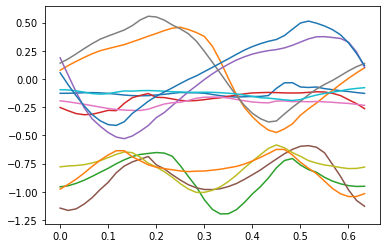

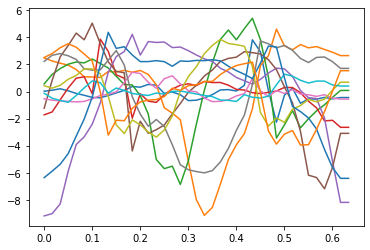

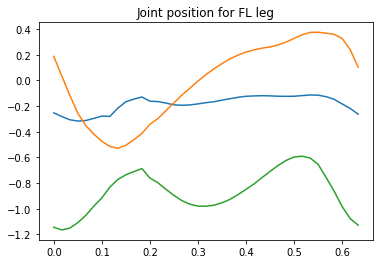

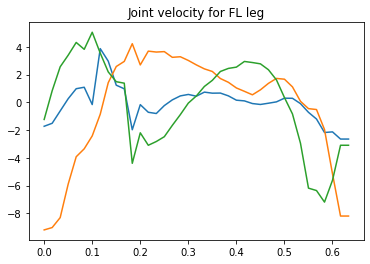

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

num_frames = motion_data.get_num_frames()
print(num_frames)
frame_dim = motion_data.get_frame(0).shape
print(frame_dim)
print(motion_data.get_duration())
frame_dur = motion_data.get_frame_duration()
print(frame_dur)

joint_positions = np.zeros((num_frames, 12))
joint_velocities = np.zeros((num_frames, 12))
for i in range(num_frames):
    frame = motion_data.get_frame(i)
    frame_vel = motion_data.get_frame_vel(i)
    joint_positions[i] = motion_data.get_frame_joints(frame)
    joint_velocities[i] = motion_data.get_frame_joints_vel(frame_vel)

plt.figure()
# Inspect the cyclicity of the pose
# plt.plot(np.arange(num_frames * 2), np.vstack([joint_positions, joint_positions]))
plt.plot(np.arange(num_frames) * frame_dur, joint_positions)
plt.figure() 
plt.plot(np.arange(num_frames) * frame_dur, joint_velocities)


plt.figure() 
plt.title("Joint position for FL leg")
plt.plot(np.arange(num_frames) * frame_dur, joint_positions[:,3:6])
plt.figure() 
plt.title("Joint velocity for FL leg")
plt.plot(np.arange(num_frames) * frame_dur, joint_velocities[:,3:6])

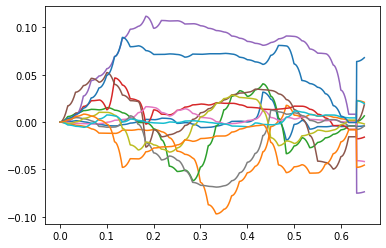

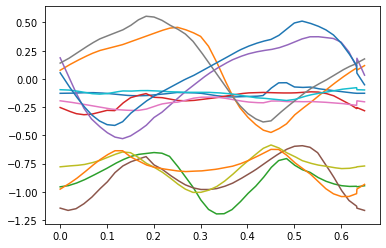

In [4]:
# Is the joint velocity consistent with the joint position trajectory? 
# Answer: Mostly yes. I think it's consistent enough
def func(y, t, motion_data):
    del y 
    frame_vel = motion_data.calc_frame_vel(t)
    joint_vel = motion_data.get_frame_joints_vel(frame_vel)
    return joint_vel

init_frame = motion_data.calc_frame(0)
y0 = motion_data.get_frame_joints(init_frame)

from scipy.integrate import odeint
t = np.linspace(0, frame_dur * num_frames, 1000)
p_calc = odeint(func, y0, t, args=(motion_data,))
p_true = np.zeros_like(p_calc)
for i, t_ in enumerate(t):
    frame = motion_data.calc_frame(t_)
    p_true[i] = motion_data.get_frame_joints(frame)

plt.figure()
plt.plot(t, p_calc - p_true)
plt.figure()
plt.plot(t, p_true)



In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

class NumpyRNGManager:
    def __init__(self, random_seed = 0):
        from numpy.random import MT19937, RandomState, SeedSequence
        self.orig_random_state = None
        self.set_random_state = RandomState(MT19937(SeedSequence(random_seed)))
    def __enter__(self):
        self.orig_random_state = np.random.get_state()
        np.random.set_state(self.set_random_state)
    def __exit__(self):
        np.random.set_state(self.orig_random_state)
        self.orig_random_state = None

# Generate dynamical system dataset

def generate_dataset(motion_data, num_samples):
    times = np.random.uniform(
                low = 0.0, 
                high = motion_data.get_duration(), 
                size = num_samples
            )
    joint_positions = np.zeros((num_samples, 12))
    joint_velocities = np.zeros((num_samples, 12))
    for i, time in enumerate(times):
        frame = motion_data.calc_frame(time)
        frame_vel = motion_data.calc_frame_vel(time)
        joint_positions[i] = motion_data.get_frame_joints(frame)
        joint_velocities[i] = motion_data.get_frame_joints_vel(frame_vel)
    return joint_positions, joint_velocities


joint_pos, joint_vel = generate_dataset(motion_data, 500)
joint_pos_tr, joint_pos_te, joint_vel_tr, joint_vel_te = train_test_split(
    joint_pos, joint_vel,
    train_size = 0.8,
    random_state=0
)

print(joint_pos_tr.shape)
print(joint_pos_te.shape)
print(joint_vel_tr.shape)
print(joint_vel_te.shape)

(400, 12)
(100, 12)
(400, 12)
(100, 12)


0.30771705157911056
0.9853069643077726 0.0


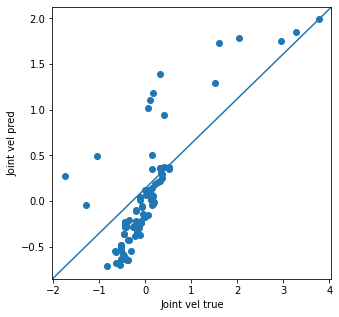

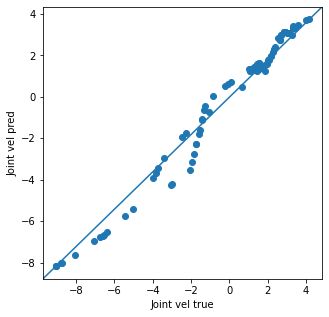

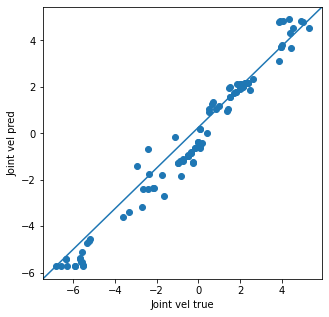

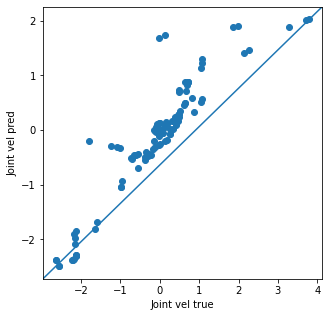

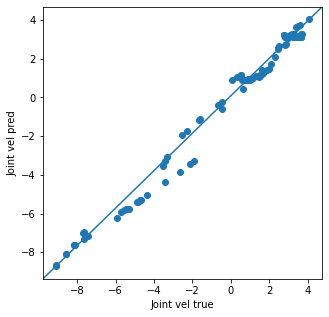

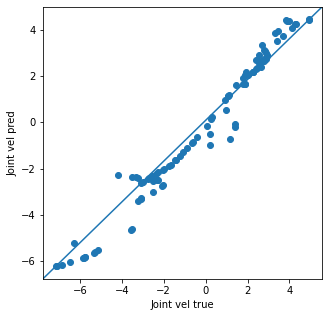

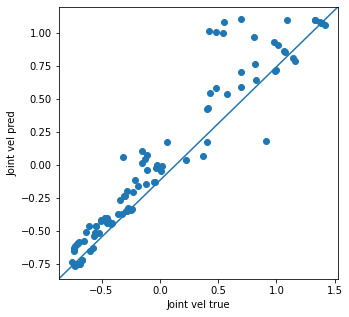

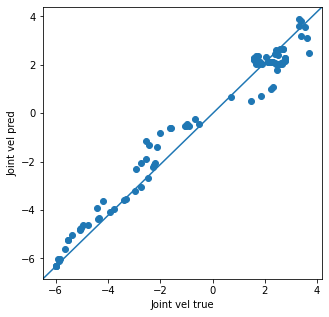

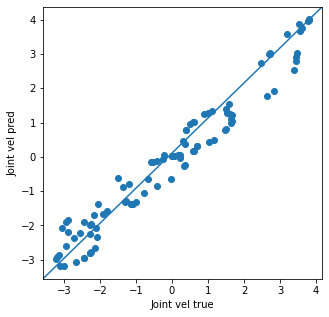

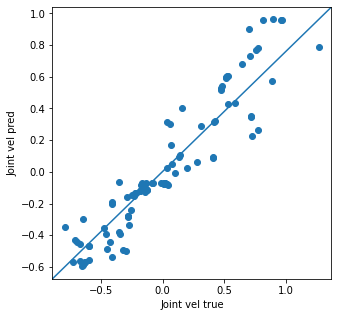

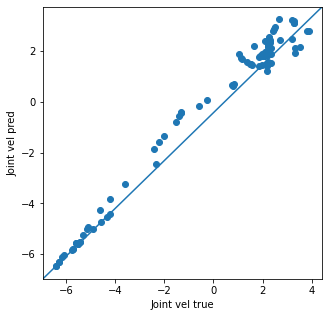

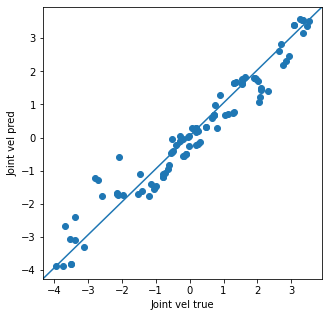

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline

def fit_polynomial_regression(X, y):

    model = Pipeline(
        [('polynomial', PolynomialFeatures(2)), 
         ('ridge', linear_model.Ridge(alpha=0.5))]
    )
    model.fit(X, y)
    return model 

model = fit_polynomial_regression(joint_pos_tr, joint_vel_tr)
joint_vel_pred = model.predict(joint_pos_te)

time = np.arange(joint_vel_te.shape[0])
for i in range(12):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(joint_vel_te[:,i], joint_vel_pred[:,i])
    ax.set_xlabel('Joint vel true')
    ax.set_ylabel('Joint vel pred')
    ax.plot([0,1],[0,1], transform=ax.transAxes)

def evaluate(y_pred, y_true):
    from sklearn.metrics import mean_absolute_error
    from scipy.stats import pearsonr

    mae = mean_absolute_error(y_true, y_pred)
    print(mae)
    corr, p = pearsonr(y_true.reshape(-1), y_pred.reshape(-1))
    print(corr, p)

evaluate(joint_vel_pred, joint_vel_te)


In [29]:
import torch 
import torch.nn as nn
import numpy as np
from dataclasses import dataclass

@dataclass
class CPGParameters:
    a: float
    b: float
    mu: float
    alpha: float
    beta: float
    gamma: float
    period: float
    dt: float


class CPG(torch.nn.Module):

    state_dim = 2

    def __init__(self, 
        params: CPGParameters, 
    ):
        super(CPG, self).__init__()
        self.params = params
        self.period = torch.nn.Parameter(data = torch.tensor(self.params.period))

    def _split_state(self, state: torch.Tensor):
        assert state.shape[-1] == 2, state.shape
        x, y = state[..., 0], state[..., 1]
        return x, y

    def forward(self, state: torch.Tensor):
        return self._calc_intrinsic_delta_state(state)

    def _calc_radius_squared(self, x, y):
        return x ** 2 + y ** 2

    def _calc_ang_vel(self, x, y):
        return (np.pi / self.params.beta / self.period / (torch.exp(-self.params.b * y) + 1)) + (
            np.pi / (1 - self.params.beta) / self.period / (torch.exp(self.params.b * y) + 1)
        )

    def _calc_intrinsic_delta_state(self, state: torch.Tensor):
        x, y = self._split_state(state)
        angvel = self._calc_ang_vel(x, y)
        radius_sq = self._calc_radius_squared(x,y)
        delta_x = self.params.alpha * (self.params.mu ** 2 - radius_sq) * x + angvel * y
        delta_y = self.params.alpha * (self.params.mu ** 2 - radius_sq) * y - angvel * x
        return torch.stack([delta_x, delta_y], axis=-1)

class Net(nn.Module):
    def __init__(self, 
        params: CPGParameters, 
    ):
        super(Net, self).__init__()
        self.params = params
        self.encoder = nn.Sequential(
            nn.Linear(6, 8),
            nn.ELU(),
            nn.Linear(8, 4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ELU(),
            nn.Linear(8, 6)
        )
        self.cpg = CPG(params)

    def get_train_loss(self, x):
        z = self.encoder(x)
        z_pos = z[:, :2]
        z_vel = z[:, 2:]
        x_pred = self.decoder(z)
        loss = nn.functional.mse_loss(x, x_pred)
        cpg_reg_loss = 0.01 * nn.functional.mse_loss(
            self.cpg(z_pos), z_vel
        )
        period_reg_loss = torch.abs(self.cpg.period)
        return loss + cpg_reg_loss  + period_reg_loss

In [30]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

params = CPGParameters(
    a=1.0,
    b=50.0,
    mu=1.0,
    alpha=10.0,
    beta=0.5,
    gamma=50.0,
    period=0.25,  # 1 second to complete a cycle
    dt=0.0167,  # 0.03 seconds = 0.001 sim_time_step * 30 action_repeat
)   

def train_new_model(cpg_params, train_loader, num_epochs = 10):
    net = Net(cpg_params)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    period_history = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss = net.get_train_loss(inputs)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
            period_history.append(net.cpg.period.item())

    print('Finished Training')
    return net, loss, period_history

In [31]:
dataset_tr = TensorDataset(
    torch.cat(
        [torch.from_numpy(joint_pos_tr[:,3:6].astype(np.float32)),
        torch.from_numpy(joint_vel_tr[:,3:6].astype(np.float32))],
        axis=1
    )
)
dataloader_tr = DataLoader(dataset_tr, shuffle=True, batch_size=10)

net, loss, period_history = train_new_model(params, dataloader_tr, num_epochs=100)  


[1,    10] loss: 0.026
[1,    20] loss: 0.022
[1,    30] loss: 0.027
[1,    40] loss: 0.023
[2,    10] loss: 0.023
[2,    20] loss: 0.021
[2,    30] loss: 0.022
[2,    40] loss: 0.017
[3,    10] loss: 0.016
[3,    20] loss: 0.016
[3,    30] loss: 0.011
[3,    40] loss: 0.010
[4,    10] loss: 0.010
[4,    20] loss: 0.009
[4,    30] loss: 0.010
[4,    40] loss: 0.009
[5,    10] loss: 0.009
[5,    20] loss: 0.009
[5,    30] loss: 0.009
[5,    40] loss: 0.009
[6,    10] loss: 0.009
[6,    20] loss: 0.008
[6,    30] loss: 0.008
[6,    40] loss: 0.007
[7,    10] loss: 0.007
[7,    20] loss: 0.006
[7,    30] loss: 0.007
[7,    40] loss: 0.006
[8,    10] loss: 0.007
[8,    20] loss: 0.004
[8,    30] loss: 0.003
[8,    40] loss: 0.004
[9,    10] loss: 0.003
[9,    20] loss: 0.003
[9,    30] loss: 0.003
[9,    40] loss: 0.002
[10,    10] loss: 0.002
[10,    20] loss: 0.002
[10,    30] loss: 0.002
[10,    40] loss: 0.002
[11,    10] loss: 0.001
[11,    20] loss: 0.002
[11,    30] loss: 0.002
[11,

0.08228186517953873


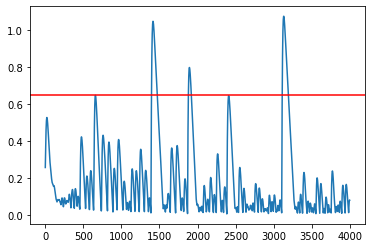

In [32]:
print(net.cpg.period.item())
plt.plot(np.arange(4000), period_history)
plt.axhline(xmin = 0, xmax = 4, y = 0.65, color = 'r')

In [ ]:
cpg = net.cpg

initial_state = cpg.